In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy import random
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score 
from statsmodels.tsa.ar_model import AutoReg
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt

# Data collection

In [6]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

# Descriptive statistics

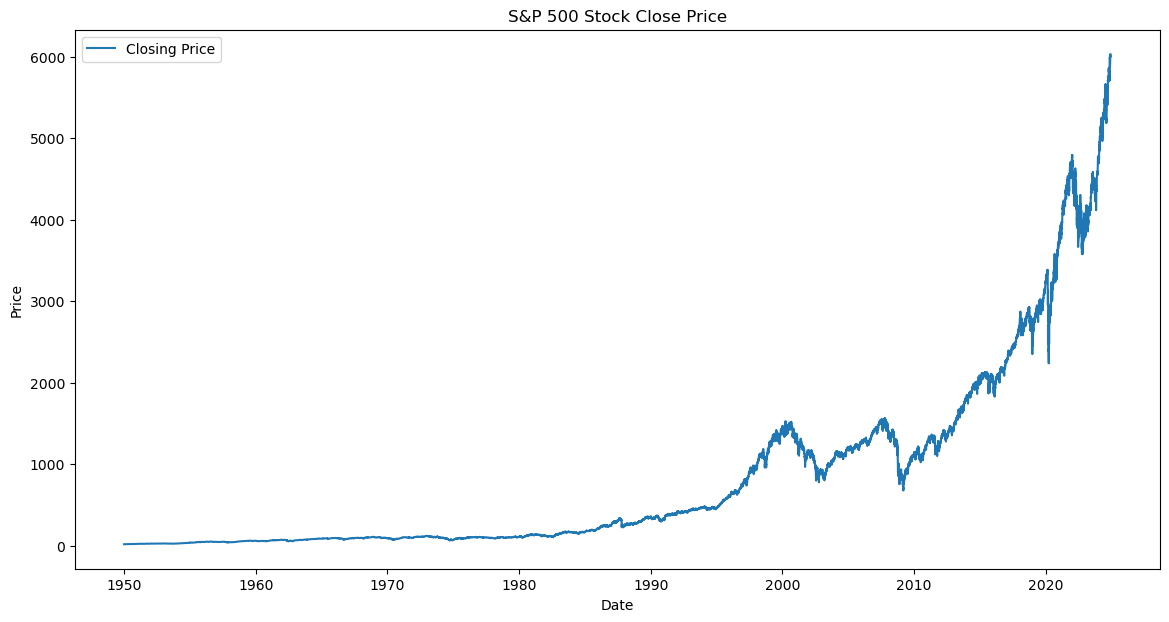

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(daily.index, daily['Close'], label='Closing Price')
plt.title('S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig("./Figures/Close_all.png", format='png', dpi=300)  
plt.show()

In [17]:
clean_daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
clean_daily.loc[(clean_daily['Open'] == 0), 'Open'] = np.nan
clean = clean_daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
clean = clean.dropna()

descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [clean['Open'].min(), clean['High'].min(), clean['Low'].min(), clean['Close'].min()],
    "Max": [clean['Open'].max(), clean['High'].max(), clean['Low'].max(), clean['Close'].max()],
    "Mean": [clean['Open'].mean(), clean['High'].mean(), clean['Low'].mean(), clean['Close'].mean()],
    "Std.": [clean['Open'].std(), clean['High'].std(), clean['Low'].std(), clean['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('./Data/summary_table.csv', index=False, sep=';')

latex_table = summary_table.to_latex(index=False, float_format="%.2f")

with open("./Tables/table.tex", "w") as file:
    file.write(latex_table)

summary_table

[*********************100%%**********************]  1 of 1 completed


,Price,Min,Max,Mean,Std.
0,Open,16.66,5757.73,1098.44,1235.74
1,High,17.09,6044.17,1136.18,1279.12
2,Low,16.66,5696.51,1061.21,1195.06
3,Close,17.05,6032.38,1106.73,1248.43


# Model Selection

In [20]:
# Method 1 : visual choice
sample = monthly[563:803] #1996-12-01 to 2016-11-30
sample = sample[sample.columns[1:5]]
monthly = monthly[monthly.columns[1:5]]

# Number of observations for each iteration
T = 120

AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(42)
    a, b, c, d = [], [], [], []

    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        if first_time:
            model = GaussianHMM(n_components=n, n_iter=T)
            first_time = False
        else:
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=T)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Baum-Welch algorithm
        model.fit(sample[i:i+T])

        # Forward algorithm
        log_likelihoods, fwd = model.score_samples(sample[i:i+T])

        k = n**2 + 2*n - 1

        aic = -2 * log_likelihoods + 2 * k
        bic = -2 * log_likelihoods + k * np.log(4 * T)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

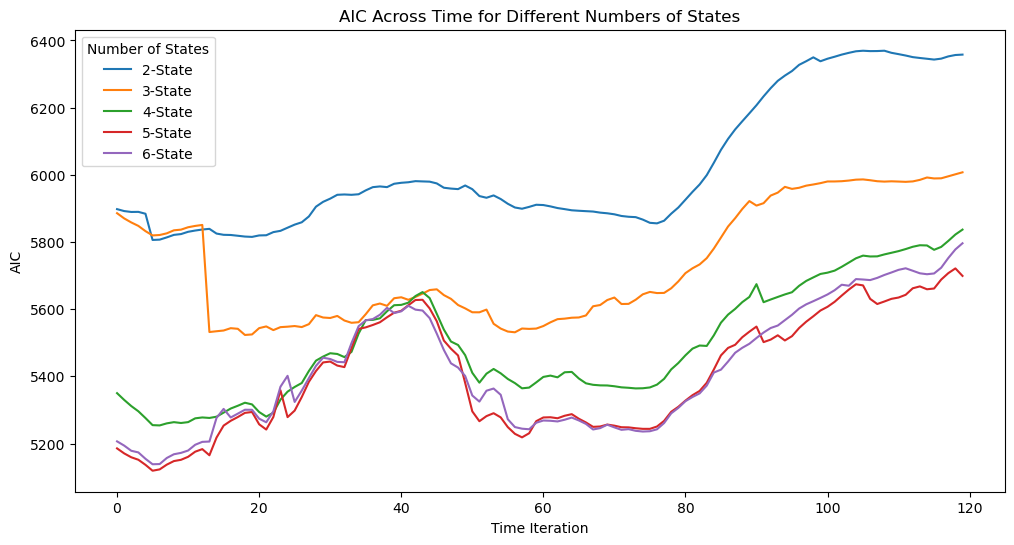

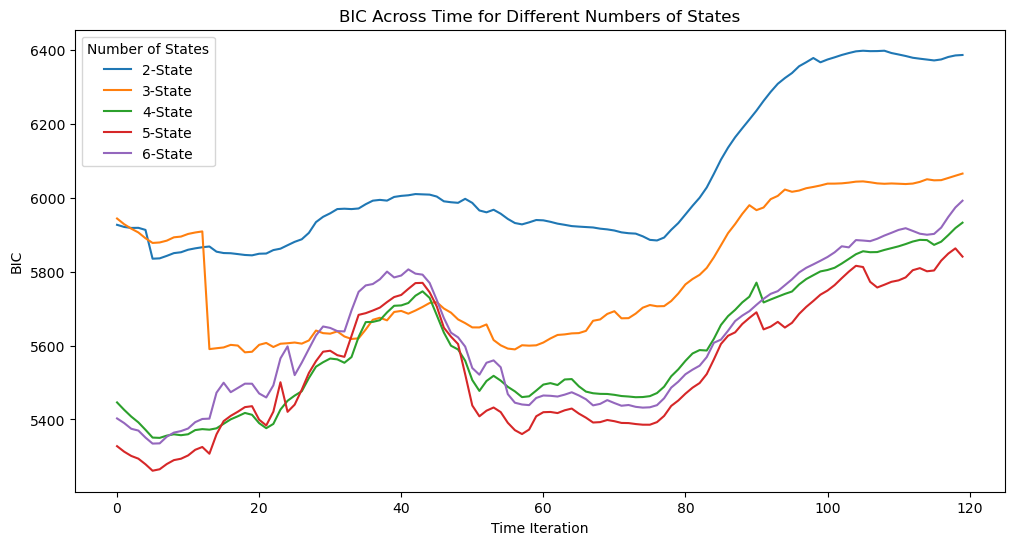

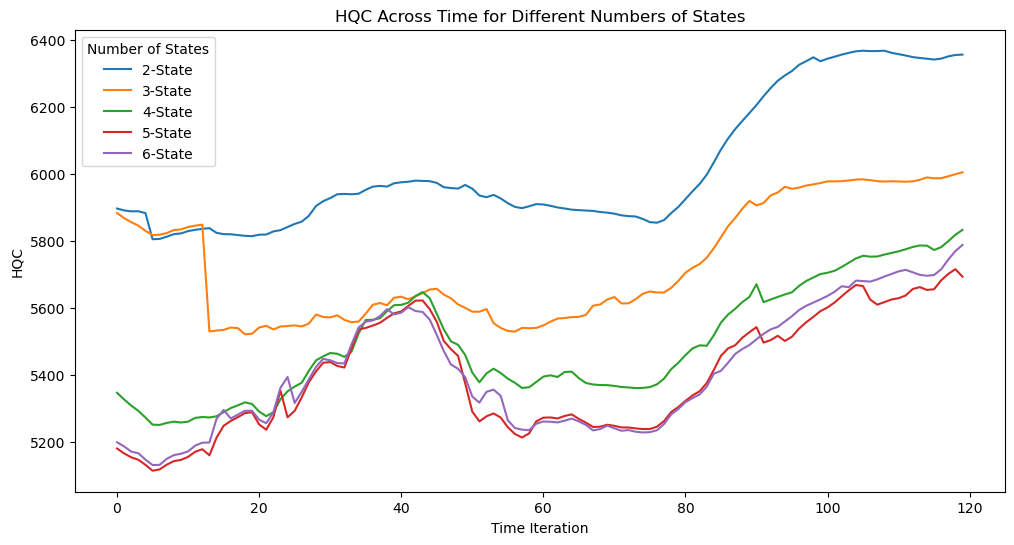

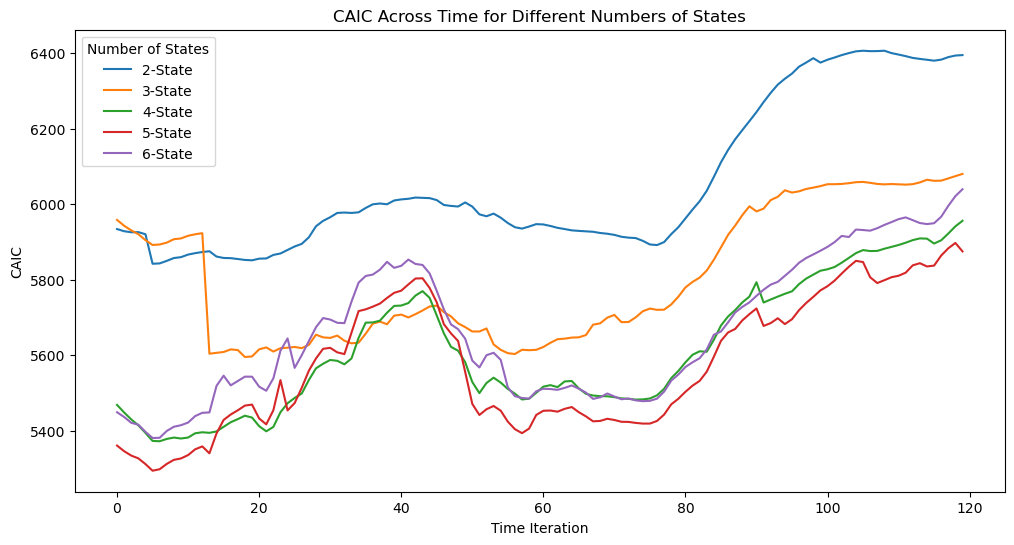

In [21]:
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.legend(title="Number of States")
plt.savefig("./Figures/AIC_plot.png", format='png')  
plt.show()

plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.legend(title="Number of States")
plt.savefig("./Figures/BIC_plot.png", format='png')  
plt.show()

plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.legend(title="Number of States")
plt.savefig("./Figures/HQC_plot.png", format='png') 
plt.show()

plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.legend(title="Number of States")
plt.savefig("./Figures/CAIC_plot.png", format='png')  
plt.show()

In [23]:
# Method 2 : algoritmic choice 
# Same obervations as before
state_range = range(2, 7) 
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(sample)
T=120

#M as number of observations, k as number of parameters 
def calculate_model_criteria(hmm_model, M, k):                  
    L = hmm_model.score(sample)                                   
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=42)
    model.fit(sample)

    num_params = num_states ** 2 + 2 * num_states - 1
    
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

Best Model Criteria: {'AIC': 11454.253724712642, 'BIC': 11534.308419949508, 'HQC': 11486.509922269302, 'CAIC': 11557.308419949508}
47
6


# Prediction using HMM

In [27]:
# Calculate number of rows and set training window
T = 779  # Set the starting point for training data (from row 1 to row 779 leaving 120 o-o-s obs)

# Training window
d = 120
D = 120
hmm_price = []

temp_T = T
first_time = True

# Sliding window to predict future prices
while T < temp_T + d:

    train_data = monthly.iloc[T-D:T]
    train_data = train_data.dropna()

    np.random.seed(42)

    if(first_time):
        first_time = False
        model = hmm.GaussianHMM(n_components=6) # 5 or 6
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=6, init_params="c") # here too
        model.startprob_ = old_model.startprob_
        model.transmat_ = old_model.transmat_
        model.means_ = old_model.means_

    model.fit(train_data)

    original_likelihood = model.score(train_data)

    # New likelihood
    t = T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t - D > 0:
        t = t - 1

        train_data = monthly.iloc[t - D:t]
        new_likelihood = model.score(train_data)
        if abs(new_likelihood - original_likelihood) < min_diff:  # Threshold for comparison
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Predicted close price
    close_price = monthly['Close'][T - 1] + ((monthly['Close'][min_t + 1] - monthly['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T = T + 1

close = []
truncated_obs = monthly.iloc[779:]

for i in truncated_obs['Close']:
    close.append(i)

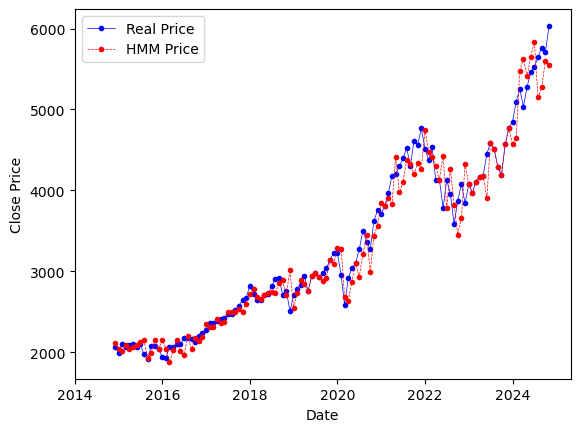

In [28]:
dates = monthly_with_dates.index[779:]

plt.plot(dates, close, marker='.', label="Real Price", color='blue', linewidth=0.5)
plt.plot(dates, hmm_price, marker='.', label="HMM Price", color='red', linewidth=0.5, linestyle='--')

plt.xlabel("Date")
plt.ylabel("Close Price")


years = dates.year.unique()
ticks = [year for year in years if year % 2 == 0]  # Show ticks every 5 years

plt.xticks(pd.to_datetime([f"{year}-01-01" for year in ticks]))
plt.gca().set_xticklabels([f"{year}" for year in ticks])

plt.legend()
plt.savefig("./Figures/HMM_pred.png", format='png', dpi=300)  
plt.show()

# Predictions using HAR

In [30]:
T = 779 
d = 120  
D = 120 
har_price = []

for t in range(T, T + d):
    # Historical returns for the past D days
    historical_returns = monthly['Close'].pct_change().iloc[t-D:t].dropna()
    
    avg_return = historical_returns.mean()
    
    # Use the previous day's price to calculate the predicted price
    predicted_price = monthly['Close'].iloc[t-1] * (1 + avg_return)
    har_price.append(predicted_price)

# Performance Evaluation

In [32]:
observed_price = pd.DataFrame(close)
observed_price = observed_price.round(2)
observed_price.to_csv('./Data/observed_price.csv', index=False, sep=';')

hmm_price = pd.DataFrame(hmm_price)
hmm_price = hmm_price.round(2)
hmm_price.to_csv('./Data/predicted_price.csv', index=False, sep=';')

har_price = pd.DataFrame(har_price)
har_price = har_price.round(2)
har_price.to_csv('./Data/predicted_har_price.csv', index=False, sep=';')

In [33]:
RMSE_hmm = root_mean_squared_error(observed_price, hmm_price)
RMSE_har = root_mean_squared_error(observed_price, har_price)

In [34]:
r2_hmm = r2_score(observed_price, hmm_price)
r2_har = r2_score(observed_price, har_price)

In [35]:
MAPE_hmm = mean_absolute_percentage_error(observed_price, hmm_price)
MAPE_har = mean_absolute_percentage_error(observed_price, har_price)

In [36]:
def aae(observed, predicted):
    return np.mean(np.abs(observed - predicted))

def arpe(observed, predicted):
    N = len(observed)
    return np.mean(np.abs((observed - predicted) / N))

AAE_hmm = aae(observed_price, hmm_price)
AAE_har = aae(observed_price, har_price)

ARPE_hmm = arpe(observed_price, hmm_price)
ARPE_har = arpe(observed_price, har_price)

In [37]:
# Efficiency measure
MAPE_eff = 1 - MAPE_hmm/MAPE_har
AAE_eff = 1 - AAE_hmm/AAE_har
ARP_eff = 1 - ARPE_hmm/ARPE_har
RMSE_eff = 1 - RMSE_hmm/RMSE_har

In [38]:
performance = {
    "Model": ["HMM", "HAR", "Efficiency"],
    "MAPE": [MAPE_hmm, MAPE_har, MAPE_eff],
    "AAE": [AAE_hmm, AAE_har, AAE_eff],
    "ARPE": [ARPE_hmm, ARPE_har, ARP_eff],
    "RMSE": [RMSE_hmm, RMSE_har, RMSE_eff],
    "$R^2$": [r2_har, r2_hmm, '']
}

performance_table = pd.DataFrame(performance)

latex_table2 = performance_table.to_latex(index=False, float_format="%.2f")

with open("./Tables/performance.tex", "w") as file:
    file.write(latex_table2)

performance_table

,Model,MAPE,AAE,ARPE,RMSE,$R^2$
0,HMM,0.040965,143.931000,1.199425,211.551060,0.979022
1,HAR,0.033619,114.800417,0.956670,155.173386,0.96101
2,Efficiency,-0.218492,-0.253750,-0.253750,-0.363321,


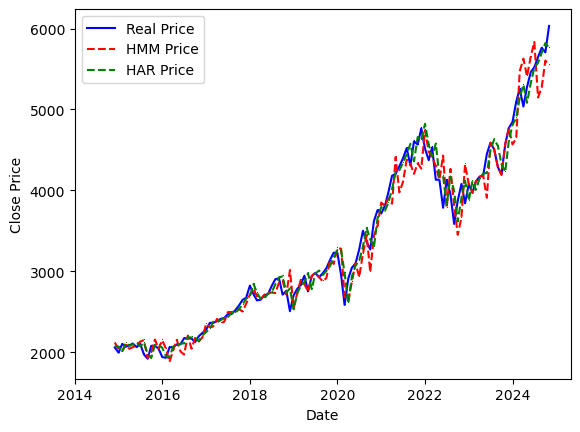

In [57]:
dates2 = monthly_with_dates.index[779:]

plt.plot(dates2, observed_price,marker=',', label = "Real Price", color='blue')
plt.plot(dates2, hmm_price,marker=',', label = "HMM Price", color='red', linestyle='--')
plt.plot(dates2, har_price,marker = ',', label= "HAR Price", color='green', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Close Price")

years = dates2.year.unique()
ticks = [year for year in years if year % 2 == 0] 

# Set x-ticks to those years
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in ticks]))
plt.gca().set_xticklabels([f"{year}" for year in ticks])
plt.legend()
plt.savefig("./Figures/Real_HAR_HMM_pred.png", format='png', dpi=300)  
plt.show()

# Stock trading strategy 

In [41]:
sp500_return = monthly_with_dates.reset_index()
sp500_return["Return"] = sp500_return["Close"].pct_change()  # Monthly returns
sp500_return = sp500_return.dropna()

def trading_simulation(predicted_returns, close_prices, initial_investment=100, trading_cost=7):
    cash = 0
    shares = 0
    costs = 0
    last_traded_price = close_prices.iloc[0]  # Initialize with the starting price

    for ret, share_price in zip(predicted_returns, close_prices):
        if ret > 0 and shares == 0:  # Buy if positive prediction and not already holding shares
            shares = initial_investment
            cash -= share_price * initial_investment
            costs += trading_cost
            last_traded_price = share_price  # Update to the price at which we bought
        elif ret < 0 and shares > 0:  # Sell if negative prediction and holding shares
            cash += share_price * shares
            costs += trading_cost
            shares = 0
            last_traded_price = share_price  # Update to the price at which we sold

    final_value = cash + (shares * close_prices.iloc[-1])  # Remaining value includes unsold shares
    profit_percent = ((final_value - costs) / (initial_investment * last_traded_price)) * 100  # Profit percent based on initial investment

    return {
        "Investment": initial_investment * close_prices.iloc[0],
        "Earnings": final_value,
        "Cost": costs,
        "Profit (%)": profit_percent
    }


def apply_hmm(returns, n_states=6):
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=120, random_state=42)
    hmm.fit(returns.reshape(-1, 1))
    hidden_states = hmm.predict(returns.reshape(-1, 1))
    return hidden_states

def apply_har(returns, lags=3):
    model = AutoReg(returns, lags=lags).fit()
    predictions = model.predict(start=lags, end=len(returns) - 1)

    # Map predictions to buy/sell signals
    signals = np.zeros_like(returns)
    signals[lags:] = np.where(predictions > 0, 1, -1)  # Positive predictions -> buy, negative -> sell
    return signals
    
def buy_and_hold_strategy(returns):
    return np.ones_like(returns)  # Always positive (buy)

time_periods = [
    {"start": "2021-07", "end": "2024-11", "months": 40},
    {"start": "2019-12", "end": "2024-11", "months": 60},
    {"start": "2018-04", "end": "2024-11", "months": 80},
    {"start": "2015-08", "end": "2024-11", "months": 100},
    {"start": "2014-11", "end": "2024-11", "months": 120}
]

results = []

for period in time_periods:
    period_data = sp500_return[(sp500_return["Date"] >= period["start"]) & (sp500_return["Date"] <= period["end"])]
    returns = period_data["Return"].values
    close_prices = period_data["Close"]

    hmm_states = apply_hmm(returns)
    har_predictions = apply_har(returns)
    buy_hold_predictions = buy_and_hold_strategy(returns)

    hmm_result = trading_simulation(hmm_states, close_prices)
    har_result = trading_simulation(har_predictions, close_prices)
    buy_hold_result = trading_simulation(buy_hold_predictions, close_prices)

    results.append({
        "Period": period["months"],
        "HMM": hmm_result,
        "HAR": har_result,
        "Buy & Hold": buy_hold_result,
    })


formatted_results = []

for result in results:
    period = result['Period']
    hmm_result = result['HMM']
    har_result = result['HAR']
    buy_hold_result = result['Buy & Hold']
    
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "HMM",
        "Investment ($)": hmm_result["Investment"],
        "Earnings ($)": hmm_result["Earnings"],
        "Cost ($)": hmm_result["Cost"],
        "Profit (%)": hmm_result["Profit (%)"]
    })
    
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "HAR",
        "Investment ($)": har_result["Investment"],
        "Earnings ($)": har_result["Earnings"],
        "Cost ($)": har_result["Cost"],
        "Profit (%)": har_result["Profit (%)"]
    })
    
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "Buy & Hold",
        "Investment ($)": buy_hold_result["Investment"],
        "Earnings ($)": buy_hold_result["Earnings"],
        "Cost ($)": buy_hold_result["Cost"],
        "Profit (%)": buy_hold_result["Profit (%)"]
    })

formatted_df = pd.DataFrame(formatted_results)
formatted_df['Profit (%)'] = formatted_df['Profit (%)'].round(2)
formatted_df['Investment ($)'] = formatted_df['Investment ($)'].astype(int).apply(lambda x: f"{x:,}")
formatted_df['Earnings ($)'] = formatted_df['Earnings ($)'].astype(int).apply(lambda x: f"{x:,}")

results_tex = formatted_df.to_latex(index=False, float_format="%.2f")
with open("./Tables/trading1.tex", "w") as file:
    file.write(results_tex)
    
formatted_df

Fitting a model with 47 free scalar parameters with only 41 data points will result in a degenerate solution.


,Trading Period,Model,Investment ($),Earnings ($),Cost ($),Profit (%)
0,40 months,HMM,"439,525","163,712",7,37.25
1,40 months,HAR,"439,525","164,804",91,29.16
2,40 months,Buy & Hold,"439,525","163,712",7,37.25
3,60 months,HMM,"323,078","280,159",7,86.71
4,60 months,HAR,"323,078","278,536",77,54.64
5,60 months,Buy & Hold,"323,078","280,159",7,86.71
6,80 months,HMM,"264,805","338,432",7,127.80
7,80 months,HAR,"264,805","261,028",119,51.20
8,80 months,Buy & Hold,"264,805","338,432",7,127.80
9,100 months,HMM,"197,218","406,019",7,205.87
